In [ ]:
!pip install xformers

In [1]:
!git clone https://github.com/KetanMann/Class_Conditioned_Diffusion_Training_Script

Cloning into 'Class_Conditioned_Diffusion_Training_Script'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 64 (delta 35), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (64/64), 653.31 KiB | 4.21 MiB/s, done.


In [2]:
!pip install git+https://github.com/huggingface/diffusers   

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-h3txdwdh
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-h3txdwdh
  Resolved https://github.com/huggingface/diffusers to commit 8690e8b9d6e68b3aec28f7f84374dd8256e79f18
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.30.0.dev0-py3-none-any.whl size=2332347 sha256=a4d20d412b27509557e3f3d789de26f3216d9788a44bea40a7a1e5f3146a3199
  Stored in directory: /tmp/pip-ephem-wheel-cache-myauhc91/wheels/f7/7d/99/d361489e5762e3464b3811bc629e94cf5bf5ef44dd5c3c4d52
Successfully built diffusers


In [3]:
!pip install tensorflow
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires ptxcompiler, which is not installed.
cuml 24.4.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.

In [ ]:
import wandb
 
wandb.login()

In [ ]:
!accelerate launch --multi_gpu train_conditional.py \
  --dataset_name="/kaggle/input/cifar10-pngs-in-folders/cifar10/train" \
  --resolution=32 \
  --output_dir={model_name} \
  --train_batch_size=64 \
  --dataloader_num_workers=8 \
  --eval_batch_size=64 \
  --num_epochs=2000 \
  --use_ema \
  --gradient_accumulation_steps=4 \
  --learning_rate=1e-4 \
  --lr_warmup_steps=1000 \
  --mixed_precision="no" \
  --save_images_epoch=20 \
  --ddpm_beta_schedule="squaredcos_cap_v2" \
  --checkpointing_steps=2000 \
  --resume_from_checkpoint="latest" \
  --enable_xformers_memory_efficient_attention \
  --prediction_type="sample" \
  --logger="wandb"

In [6]:
%%writefile sample.py
import torch
from diffusers import UNet2DModel, DDPMScheduler
from diffusers.pipelines.pipeline_utils import DiffusionPipeline, ImagePipelineOutput
from diffusers.utils.torch_utils import randn_tensor
from typing import List, Optional, Tuple, Union
import os
from PIL import Image
import matplotlib.pyplot as plt

class DDPMPipelinenew(DiffusionPipeline):
    def __init__(self, unet, scheduler, num_classes: int):
        super().__init__()
        self.register_modules(unet=unet, scheduler=scheduler)
        self.num_classes = num_classes
        self._device = unet.device  # Ensure the pipeline knows the device

    @torch.no_grad()
    def __call__(
        self,
        batch_size: int = 64,
        class_labels: Optional[torch.Tensor] = None,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        num_inference_steps: int = 1000,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ) -> Union[ImagePipelineOutput, Tuple]:
        
        # Ensure class_labels is on the same device as the model
        class_labels = class_labels.to(self._device)
        if class_labels.ndim == 0:
            class_labels = class_labels.unsqueeze(0).expand(batch_size)
        else:
            class_labels = class_labels.expand(batch_size)

        # Sample gaussian noise to begin loop
        if isinstance(self.unet.config.sample_size, int):
            image_shape = (
                batch_size,
                self.unet.config.in_channels,
                self.unet.config.sample_size,
                self.unet.config.sample_size,
            )
        else:
            image_shape = (batch_size, self.unet.config.in_channels, *self.unet.config.sample_size)

        image = randn_tensor(image_shape, generator=generator, device=self._device)

        # Set step values
        self.scheduler.set_timesteps(num_inference_steps)

        for t in self.progress_bar(self.scheduler.timesteps):
            # Ensure the class labels are correctly broadcast to match the input tensor shape
            model_output = self.unet(image, t, class_labels).sample

            image = self.scheduler.step(model_output, t, image, generator=generator).prev_sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image,)

        return ImagePipelineOutput(images=image)

    def to(self, device: torch.device):
        self._device = device
        self.unet.to(device)
        return self

def load_pipeline(model_path, scheduler_path, num_classes, device):
    unet = UNet2DModel.from_pretrained(model_path).to(device)
    scheduler = DDPMScheduler.from_pretrained(scheduler_path)
    pipeline = DDPMPipelinenew(unet=unet, scheduler=scheduler, num_classes=num_classes)
    return pipeline.to(device)  # Move the entire pipeline to the device

def save_images_locally(images, save_dir, epoch, class_label):
    os.makedirs(save_dir, exist_ok=True)
    for i, image in enumerate(images):
        image_path = os.path.join(save_dir, f"image_epoch{epoch}_class{class_label}_idx{i}.png")
        image.save(image_path)

def generate_images(pipeline, class_label, batch_size, num_inference_steps, save_dir, epoch):
    generator = torch.Generator(device=pipeline._device).manual_seed(0)
    class_labels = torch.tensor([class_label] * batch_size).to(pipeline._device)
    images = pipeline(
        generator=generator,
        batch_size=batch_size,
        num_inference_steps=num_inference_steps,
        class_labels=class_labels,
        output_type="pil",
    ).images
    save_images_locally(images, save_dir, epoch, class_label)
    return images

def create_image_grid(images, grid_size, save_path):
    assert len(images) == grid_size ** 2, "Number of images must be equal to grid_size squared"
    width, height = images[0].size
    grid_img = Image.new('RGB', (grid_size * width, grid_size * height))
    
    for i, image in enumerate(images):
        x = i % grid_size * width
        y = i // grid_size * height
        grid_img.paste(image, (x, y))
    
    grid_img.save(save_path)
    return grid_img

if __name__ == "__main__":
    model_path = "/kaggle/input/calmness/checkpoint-22000/unet"
    scheduler_path = "/kaggle/input/calmness/scheduler"
    num_classes = 10  # Adjust to your number of classes
    batch_size = 64
    num_inference_steps = 1000 # Can be as low as 50 for faster generation
    save_dir = "generated_images"
    epoch = 0
    grid_size = 8  # 8x8 grid

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pipeline = load_pipeline(model_path, scheduler_path, num_classes, device)
    
    for class_label in range(num_classes):
        images = generate_images(pipeline, class_label, batch_size, num_inference_steps, save_dir, epoch)
        
        # Create and save the grid image
        grid_img_path = os.path.join(save_dir, f"grid_image_class{class_label}.png")
        grid_img = create_image_grid(images, grid_size, grid_img_path)
        
        # Plot the grid image
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_img)
        plt.axis('off')
        plt.title(f'Class {class_label}')
        plt.savefig(os.path.join(save_dir, f"grid_image_class{class_label}.png"))
        plt.show()

Overwriting sample.py


In [7]:
!python sample.py

2024-07-01 01:46:59.149481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 01:46:59.149542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 01:46:59.151042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
100%|███████████████████████████████████████| 1000/1000 [01:54<00:00,  8.76it/s]


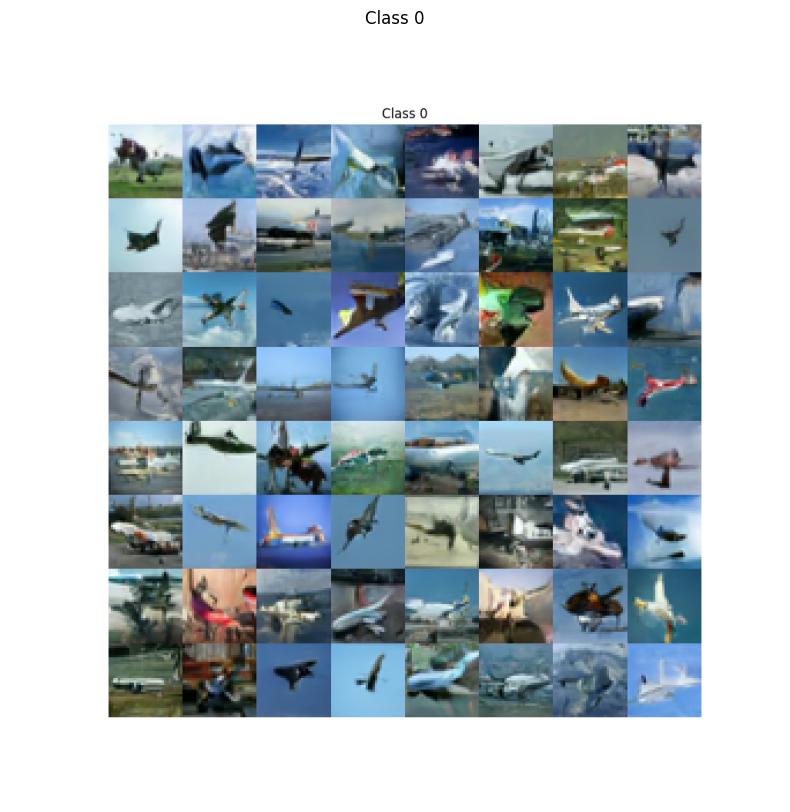

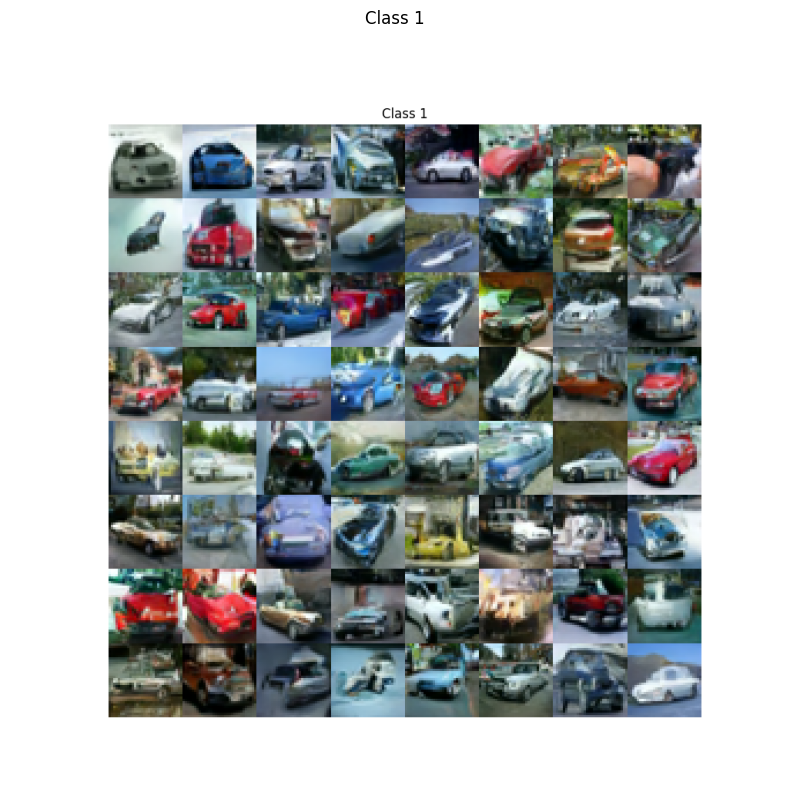

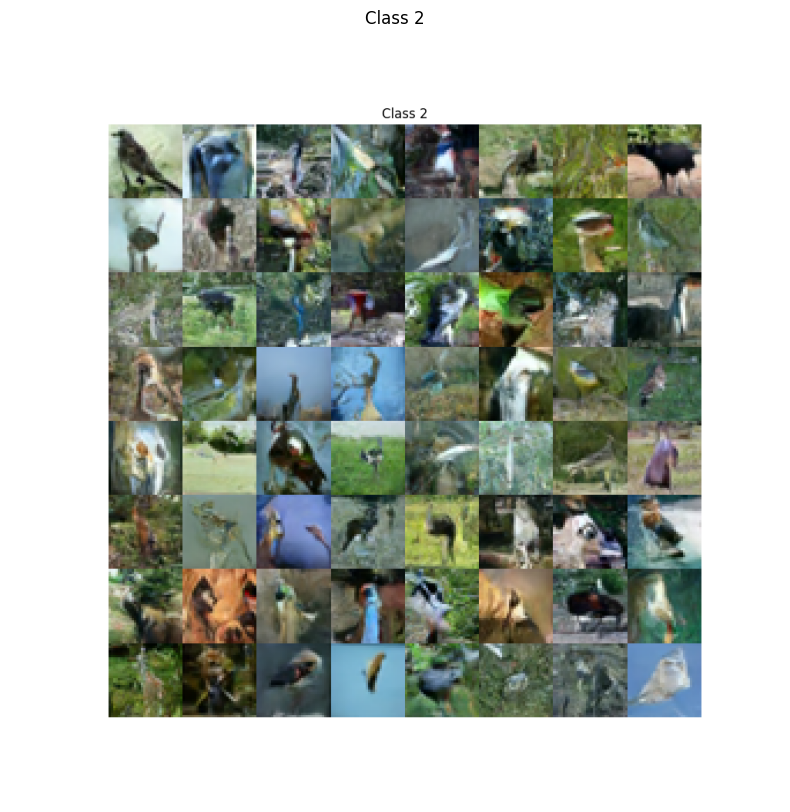

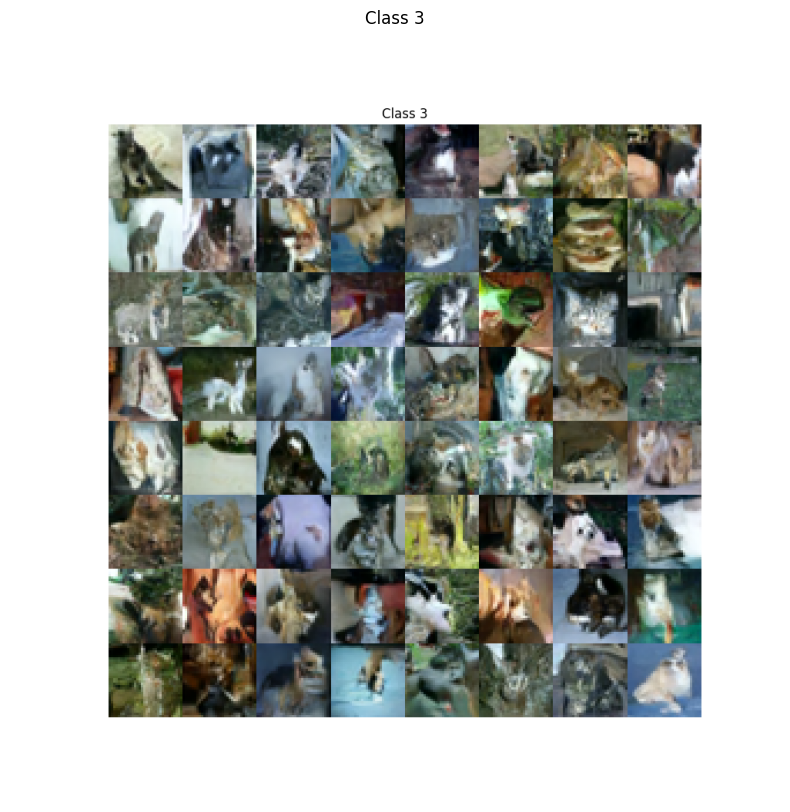

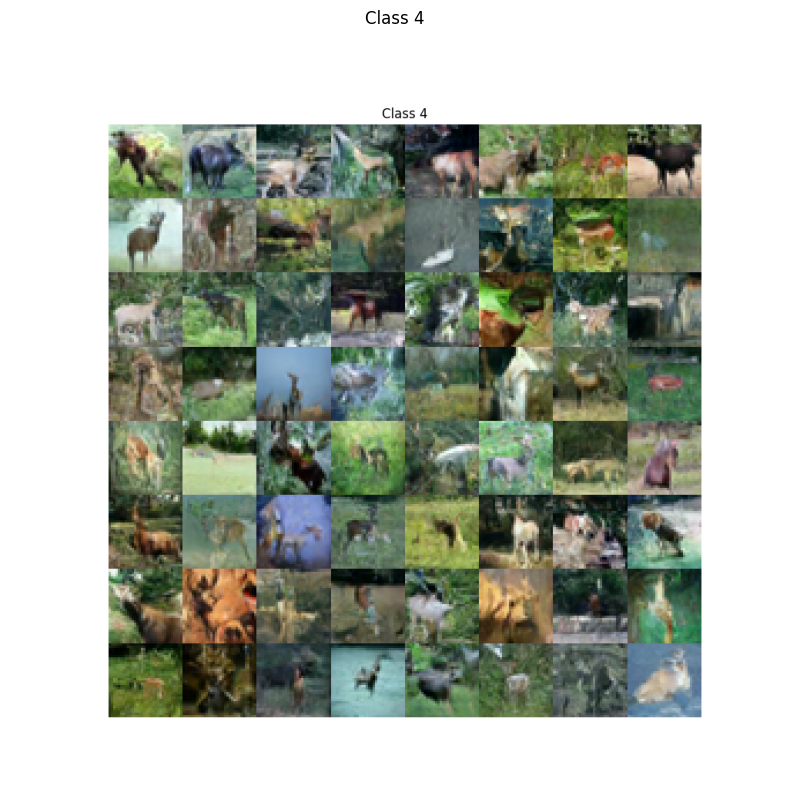

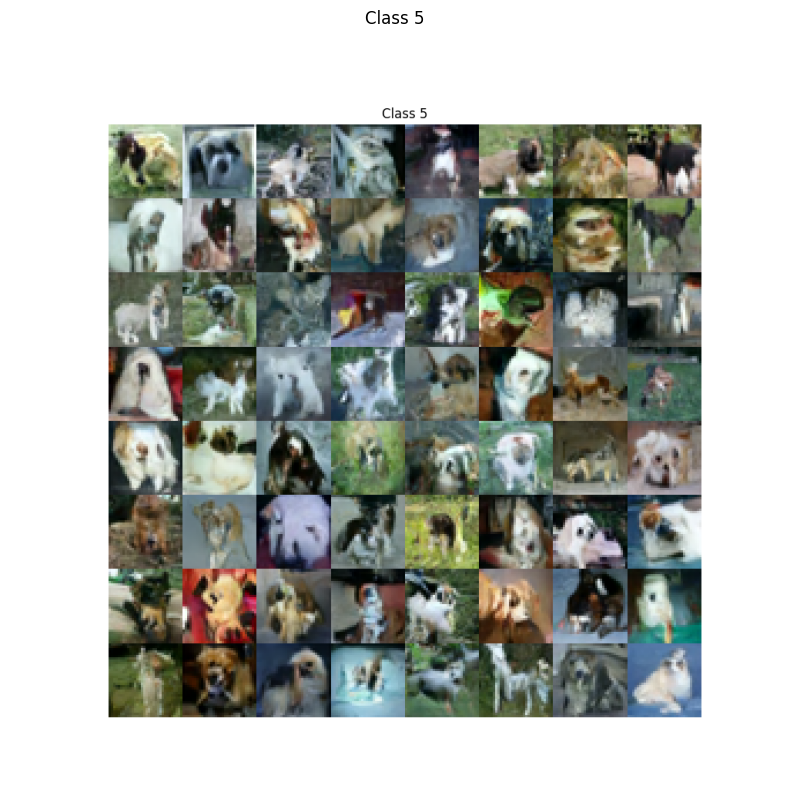

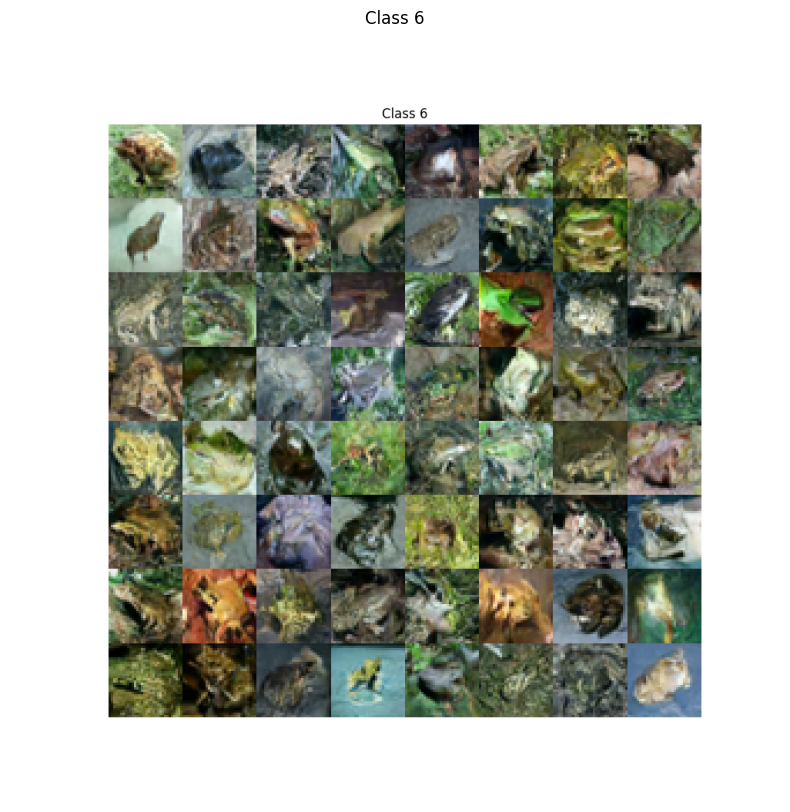

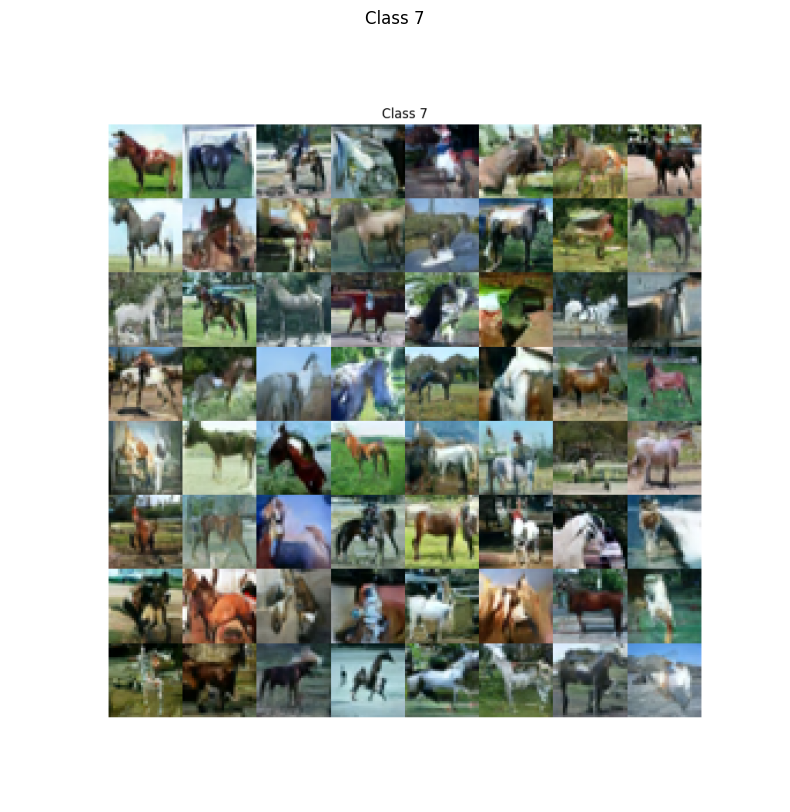

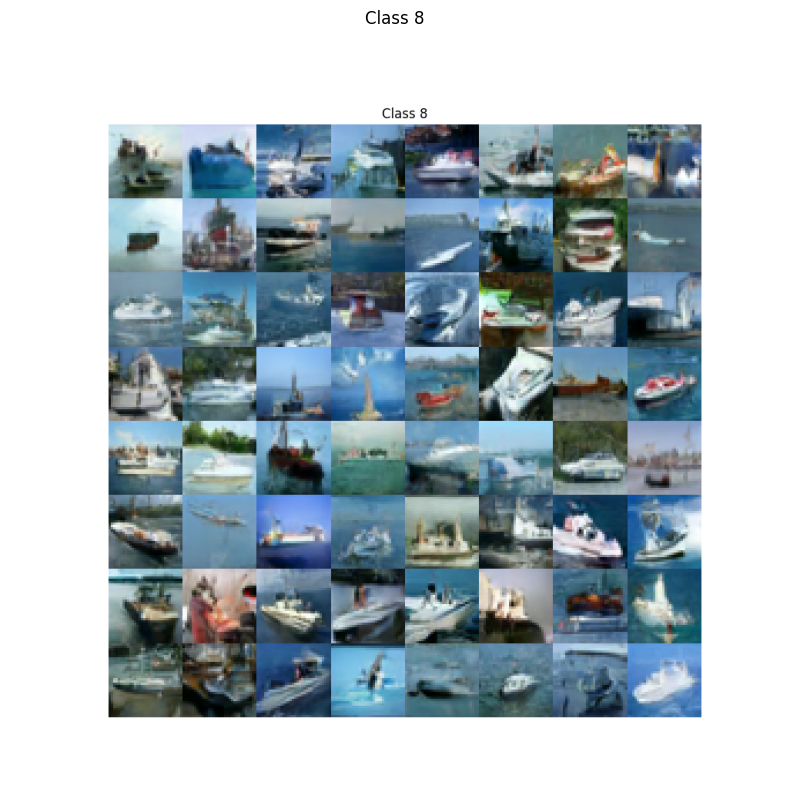

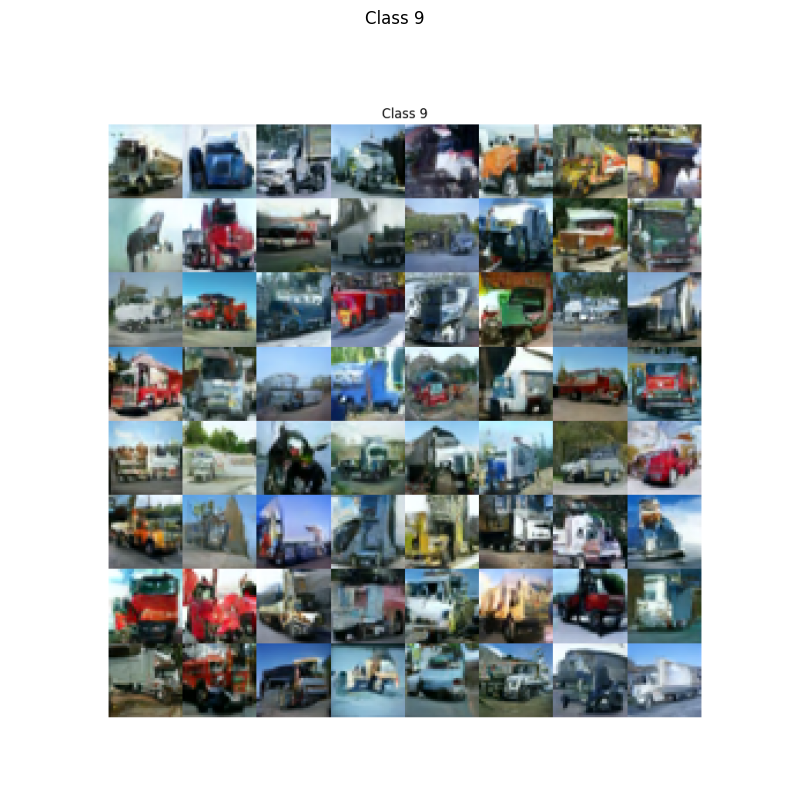

In [8]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def plot_saved_grid_images(save_dir, num_classes, grid_image_prefix="grid_image_class"):
    for class_label in range(num_classes):
        grid_img_path = os.path.join(save_dir, f"{grid_image_prefix}{class_label}.png")
        if os.path.exists(grid_img_path):
            grid_img = Image.open(grid_img_path)
            
            # Plot the grid image
            plt.figure(figsize=(10, 10))
            plt.imshow(grid_img)
            plt.axis('off')
            plt.title(f'Class {class_label}')
            plt.show()
        else:
            print(f"Grid image for class {class_label} not found at {grid_img_path}")

if __name__ == "__main__":
    save_dir = "generated_images"
    num_classes = 10  # Adjust to your number of classes

    plot_saved_grid_images(save_dir, num_classes)
